# Computational Vision - Laboratory

==============================================================================================
## Practice 7: Image Segmentation

==============================================================================================

The main topics are:

1)	Segmentation of video shots with static scenes.

2) Background substraction.

3)	Segmentation of images.

In order to successfuly complete this practicum it is necessary to understand the following theory concepts: background substraction, K-means clustering, etc.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.

Read and visualize the sequence of images "sequences"

Hint: In order to read a  collection of images, we wil use the function animation.FuncAnimation [https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.animation.FuncAnimation.html].

Observe in the following example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

<IPython.core.display.Javascript object>


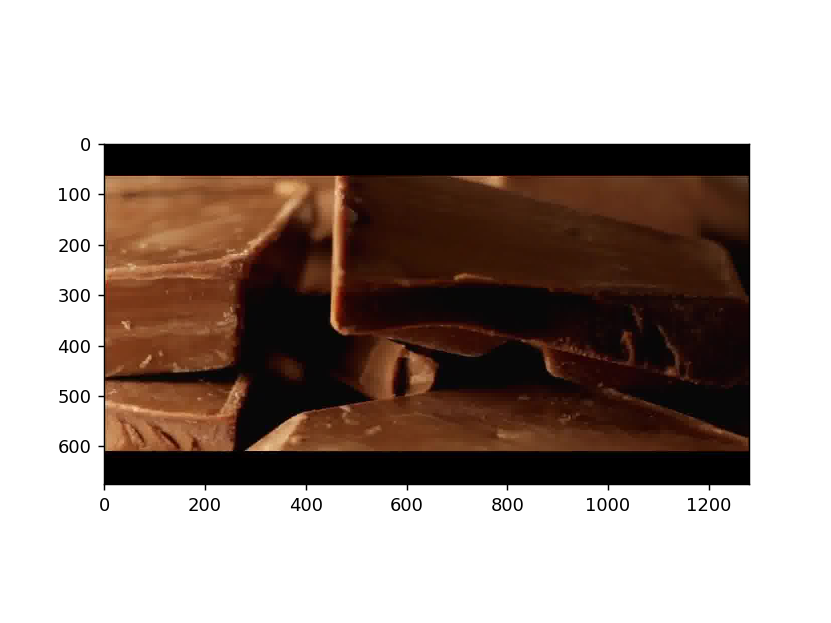

In [5]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from skimage import io

ic = io.ImageCollection('sequences/*.jpg') # Reading a sequence of images from a folder

%matplotlib notebook
%matplotlib notebook

i=0                                   # Inicializing the video display
fig = plt.figure()                    # Create figure
im = plt.imshow(ic[i], animated=True) # Visualize the first image

def updatefig1(i):                    # Updating the frame visualization
    im.set_array(ic[i*5])             # Changing the content of the canvas
    return im                         # to return a tuple!

ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=False, frames=50, repeat=False)

a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. Which measure can be used in order to visually distinguish the shots in a plot? Explain your solution.

Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/shot_detection.png">

**Hint:** take the following example of video and temporal plot visualization as a template. The plot must be replaced by a frame by frame measure to be defined by you, being applicable to distinguish the shots.

- If you need to convert the image to float, the command is: img_as_float()
- If you need the histogram, it is in skimage.exposure

<IPython.core.display.Javascript object>


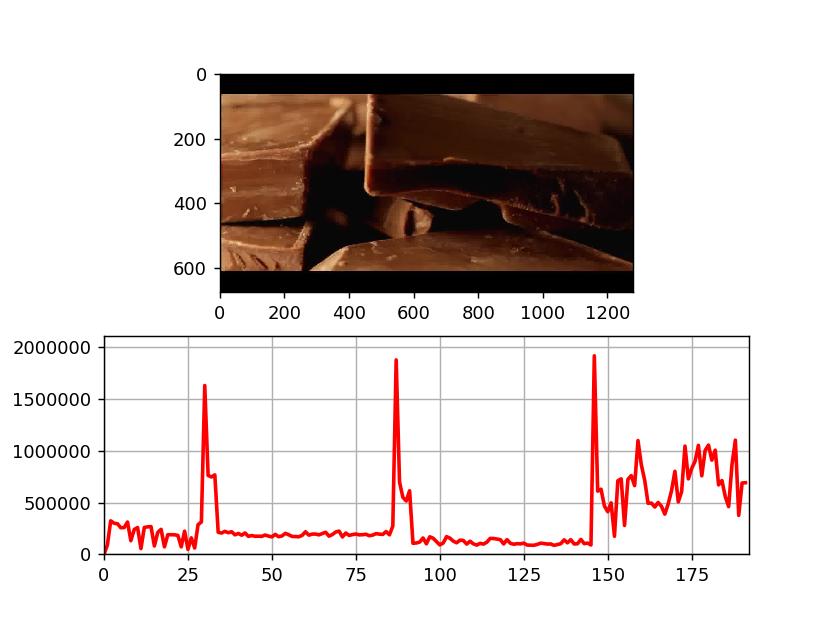

In [17]:
def get_channel_hists(image):
    image = skimage.img_as_float(image)
    r_hist, _ = skimage.exposure.histogram(image[:,:,0])
    g_hist, _ = skimage.exposure.histogram(image[:,:,1])
    b_hist, _ = skimage.exposure.histogram(image[:,:,2])
    return r_hist, g_hist, b_hist

histogram_differences = []
prev_frame = ic[0]
prev_r_hist, prev_g_hist, prev_b_hist = get_channel_hists(prev_frame)
for i in range(len(ic)):
    current_frame = ic[i]
    current_r_hist, current_g_hist, current_b_hist = get_channel_hists(current_frame)

    diff_r_hist = np.abs(current_r_hist - prev_r_hist)
    diff_g_hist = np.abs(current_g_hist - prev_g_hist)
    diff_b_hist = np.abs(current_b_hist - prev_b_hist)
    y = (diff_r_hist + diff_g_hist + diff_b_hist).sum()
    
    prev_r_hist, prev_g_hist, prev_b_hist = current_r_hist, current_g_hist, current_b_hist
    
    histogram_differences.append(y)


# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
ln, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, max(histogram_differences)*1.1)
ax2.set_xlim(0, len(histogram_differences))
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(i):
    xdata.append(i)
    ydata.append(histogram_differences[i])
    ln.set_data(xdata, ydata)

    # Plot image on top row
    ax1.imshow(ic[i])

    return ln,

ani = animation.FuncAnimation(fig, run, frames=len(histogram_differences), blit=True, interval=10, repeat=False)
plt.show()

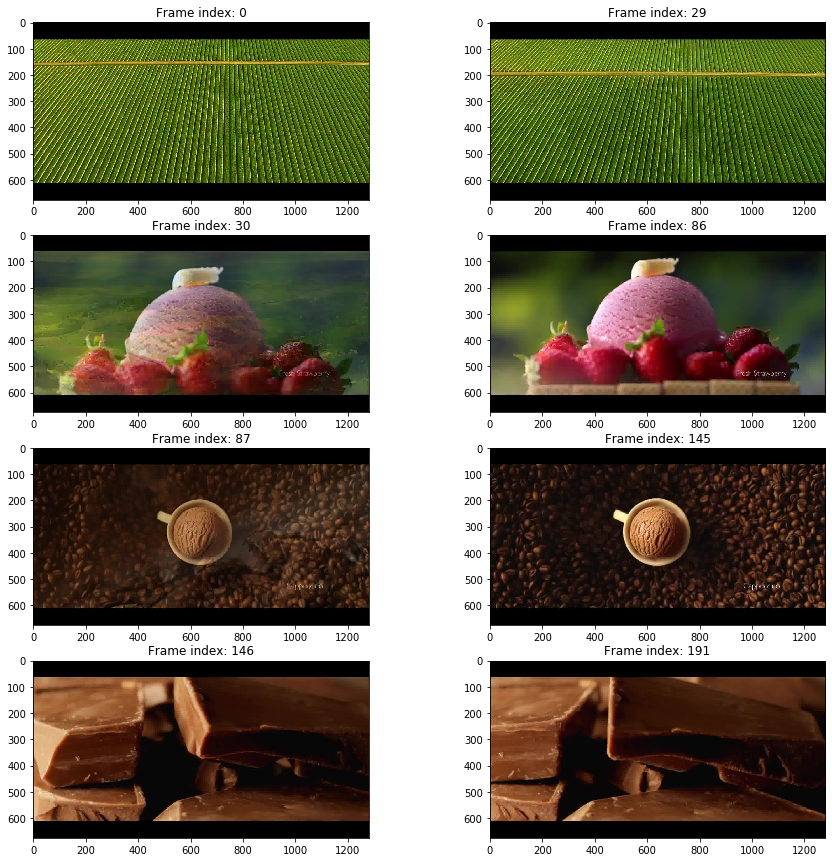

In [34]:
%matplotlib inline
%matplotlib inline
threshold = 1500000
first_last_frames_shot = [0]
for i, histogram_diff in enumerate(histogram_differences):
    if histogram_diff > threshold:
        first_last_frames_shot.append(i-1)
        first_last_frames_shot.append(i)
first_last_frames_shot.append(len(histogram_differences) - 1)

f, ax = plt.subplots(4, 2, figsize=(15, 15))

for i, frame_index in enumerate(first_last_frames_shot):
    ax[divmod(i, 2)].imshow(ic[frame_index])
    ax[divmod(i, 2)].set_title(f'Frame index: {frame_index}')
    
plt.show()

## 7.2 Background substraction

Apply the background substraction algorithm (check theory material).

Visualize, for each shot of the video:
    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: 
You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

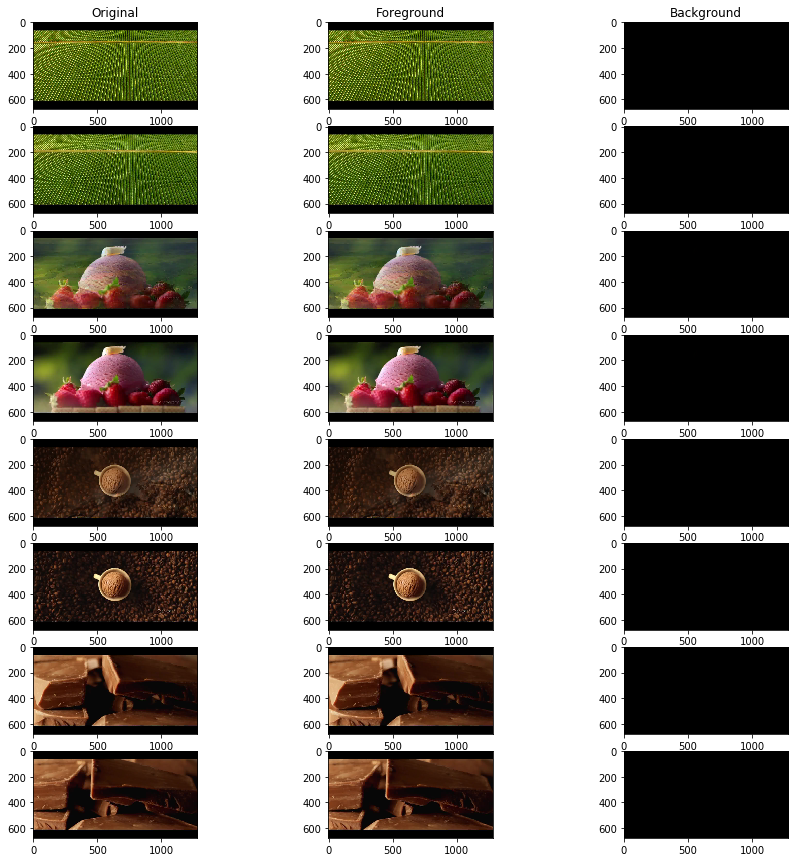

In [82]:
%matplotlib inline
%matplotlib inline
import sys
def get_background(frames):
    #all_images = frames.concatenate()
    #median = np.median(all_images, axis=0)
    #m = np.array(median, dtype=np.uint8)
    #return m
    frames = np.stack(list(map(skimage.img_as_float, frames)), axis=0)
    frames = io.collection.concatenate_images(frames)
    median_over_time = np.median(frames, axis=0).astype(np.uint8)
    #np.savetxt('array_backgorund.txt', median_over_time[:,:,0])
    #input()
    return median_over_time
    # foreground_frames = np.abs(frames - median_over_time)
    # background_frames = median_over_time

i = 0
images_to_display = []
while i < len(first_last_frames_shot):
    first_frame_idx = first_last_frames_shot[i]
    last_frame_idx = first_last_frames_shot[i+1]
    background = get_background(ic[first_frame_idx:last_frame_idx+1])
    first_frame = ic[first_frame_idx]
    #np.savetxt('array_original.txt', first_frame[:,:,0])
    
    last_frame = ic[last_frame_idx]
    first_frame_foreground = np.abs(first_frame - background)
    #np.savetxt('array_foregroundl.txt', first_frame[:,:,0])
    #input()
    last_frame_foreground = np.abs(last_frame - background)
    images_to_display.extend((first_frame, first_frame_foreground, background))
    images_to_display.extend((last_frame, last_frame_foreground, background))
    i += 2
    

f, ax = plt.subplots(8, 3, figsize=(15, 15))

for i, img in enumerate(images_to_display):
    ax[divmod(i, 3)].imshow(img)
    if i == 0:
        ax[divmod(i, 3)].set_title('Original')
    elif i == 1:
        ax[divmod(i, 3)].set_title('Foreground')
    elif i == 2:
        ax[divmod(i, 3)].set_title('Background')
    
plt.show()
# ic_test = np.stack(list(map(skimage.img_as_float64, ic[50:80])), axis=0)
#remove_background(ic[50:80])
#plt.show()

- Comment your implementation including details.
- What happens if the shots are not correctly extracted? 
- What happens if you find too many shots in the video? 
- What do the static background images represent? 
- In which situations does the algorithm work and in which it does not? 
- What happens if you substract the background image from the original one?
- Do you see any additional application for this algorithm?

**[OPTIONAL]**
Apply the algorithm to some other static video that you found.

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

- **Comment your implementation including details.**

- __What happens if the shots are not correctly extracted?__

- **What happens if you find too many shots in the video?**

- __What do the static background images represent?__

- **In which situations does the algorithm work and in which it does not?**

- __What happens if you substract the background image from the original one?__

- **Do you see any additional application for this algorithm?**

</div>

## 7.3 Clustering methods on the RGB-XY space

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)
- Add title to the figures to explain what is displayed.

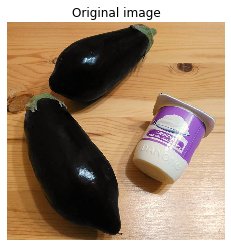

In [37]:
import skimage.segmentation as seg

%matplotlib inline

img = io.imread('images/000000001.jpg')
results = [{
    'img': img,
    'title': 'Original image'
}, None, None, None]

plt.imshow(results[0]['img'])
plt.title(results[0]['title'])
plt.axis('off')
plt.show()

a) Read any image from the folder 'images' and segment it using **Felzenszwalbs's method.**
- Test different parameters in order to obtain a good image segmentation. 
- How does each parameter behave? Which are the optimal values?
- Comment what algorithm is the method based in up to 3 lines most.

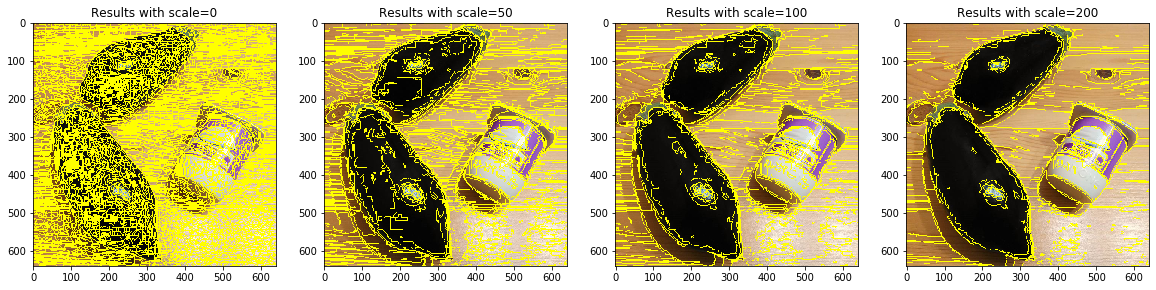

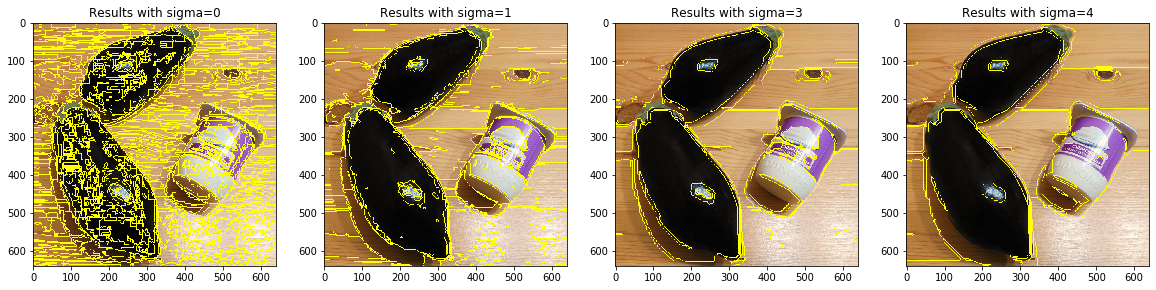

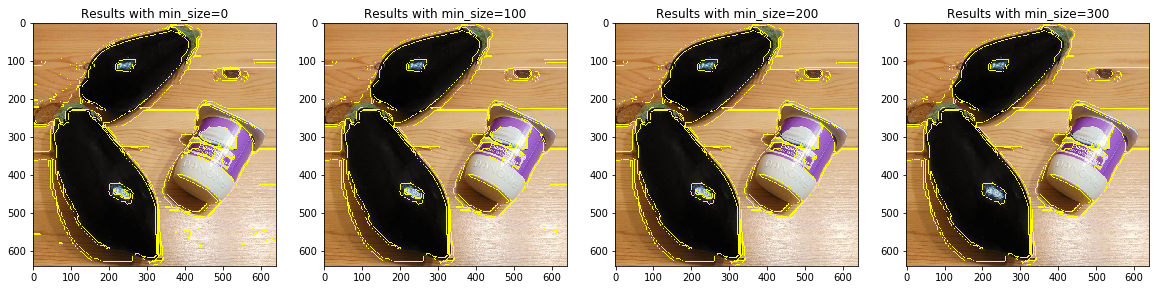

In [55]:
### SCALE

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, scale in enumerate([0, 50, 100, 200]):
    segmented_img = seg.felzenszwalb(img, scale=scale)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with scale={scale}')

plt.show()

### SIGMA

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, sigma in enumerate([0, 1, 3, 5]):
    segmented_img = seg.felzenszwalb(img, scale=200, sigma=sigma)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with sigma={sigma}')

plt.show()

### MIN_SIZE

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, min_size in enumerate([0, 100, 200, 300]):
    segmented_img = seg.felzenszwalb(img, scale=200, sigma=3, min_size=min_size)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with min_size={min_size}')

plt.show()

##########

results[1] = {
    'img': seg.felzenszwalb(img, scale=200, sigma=3, min_size=300),
    'title': 'Segmentation with Felzenszwalb\'s method'
}

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

**Effect of different parameters:**
    
We have three parameters to play with:

- __*scale*__ controls how fast the snake contracts. Using 0 the snake doesn't contract and the optimized snake is equivalent to the original one. Using 0.01 is still to slow and the snake is unable to reach the desired contour and using too large values such as 1, produce the snake to contract too fast, converging in a single point. A value of *0.1* produces good results.
- __*sigma*__ makes the output snake line smoother the greater this values is.
- __*min_size*__ sets explicitly the time step for each iterations. We've found that the default parameter *0.01* works perfectly fine.
    

**Algorithm base:** 
   
</div>

b) Segment the previous image using **SLIC algorithm.** 
- Test different parameters in order to obtain a good image segmentation.
- How does each parameter behave? Upto your opinion, which are the optimal values?
- Comment what algorithm is the method based in up to 3 lines.

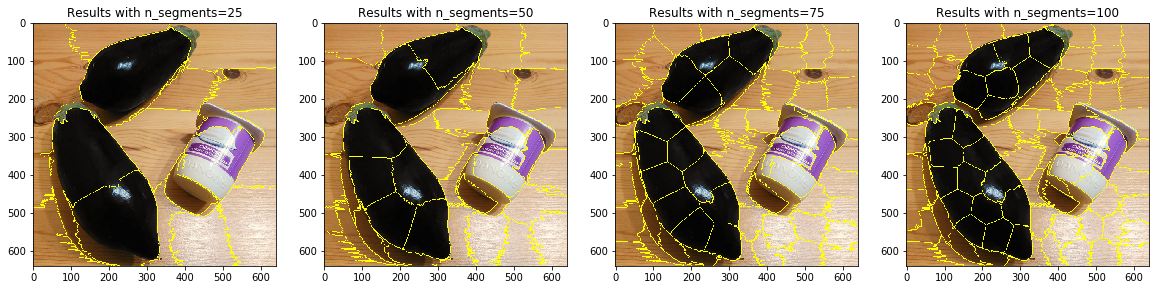

In [65]:
### N_SEGMENTS

f, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, n_segments in enumerate([25, 50, 75, 100]):
    segmented_img = seg.slic(img, n_segments=n_segments, max_iter=100)
    marked_boundaries = seg.mark_boundaries(img, segmented_img)
    ax[i].imshow(marked_boundaries)
    ax[i].set_title(f'Results with n_segments={n_segments}')

plt.show()

##########

results[2] = {
    'img': segmented_img,
    'title': 'Segmentation with SLIC algorithm'
}

c) Segment the previous image using **Quickshift algorithm.** 
- Test different parameters in order to obtain a good image segmentation.
- How does each parameter behave? Upto your opinion, which are the optimal values?
- Comment what algorithm is the method based in up to 3 lines.

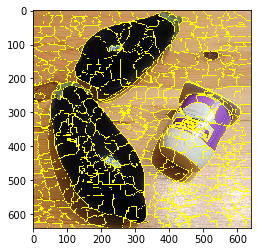

In [83]:
segmented_img = seg.quickshift(img)

# TODO: Hyperparameter optimization

results[3] = {
    'img': segmented_img,
    'title': 'Segmentation with Quickshift algorithm'
}

plt.imshow(seg.mark_boundaries(img, segmented_img))
plt.show()

d) Plot the original image and the results of the above algorithms in a 2x2 subplot.
- Calculate also the number of segments obtained on the image by each of the algorithms.
- Comment the differences between each method as well as their advantages and disadvantages.

TypeError: 'NoneType' object is not subscriptable

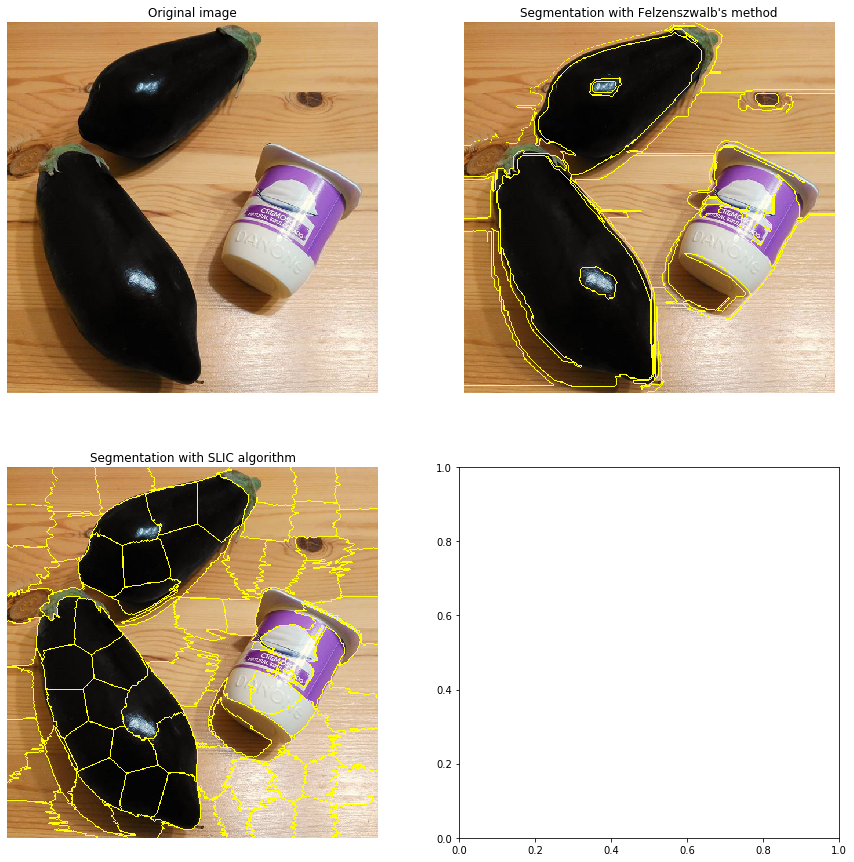

In [54]:
f, ax = plt.subplots(2, 2, figsize=(15, 15))

for idx, segmentation in enumerate(results):
    i, j = divmod(idx, 2)
    if i == 0 and j == 0:
        ax[i, j].imshow(segmentation['img'])
    else:
        segmentation_boundaries = seg.mark_boundaries(results[0]['img'], segmentation['img'])
        ax[i, j].imshow(segmentation_boundaries)
    
    ax[i, j].set_title(segmentation['title'])
    ax[i, j].axis('off')
    
plt.show()